## Sales forecasting 
--> Goal: Utilize the provided historical dataset to generate a forecast for the upcoming 6 months.

This is a time series problem, we need to use lagged values which are previous values of the time series used as predictors for future values.
 For example, to predict the value at time t, you can use the values at times t−1, t−2, etc., as features.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from hmmlearn import hmm

#### Data exploration

In [2]:
rawdata=pd.read_csv("C:/Users/Una/Documents/UU_master_programme/career/Beerwulf/assessment_data_set.csv")
rawdata

,Product,Month,Sales
0,ProductA,2019-03-01,608
1,ProductA,2019-04-01,6838
2,ProductA,2019-05-01,12195
3,ProductA,2019-06-01,26292
4,ProductA,2019-07-01,31547
...,...,...,...
122,ProductC,2022-09-01,7674
123,ProductC,2022-10-01,7582
124,ProductC,2022-11-01,5985
125,ProductC,2022-12-01,5489


In [3]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Product  127 non-null    object
 1   Month    127 non-null    object
 2   Sales    127 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


From above dataframe, the dataset contains 127 entries, capturing monthly sales data for three products spanning from 2019 to 2023.

#### Line Plot: Provide an overview of the sales trend over the years.

    Product  Number of Data Points  Duration (days)
0  ProductA                     47             1402
1  ProductB                     42             1249
2  ProductC                     38             1127


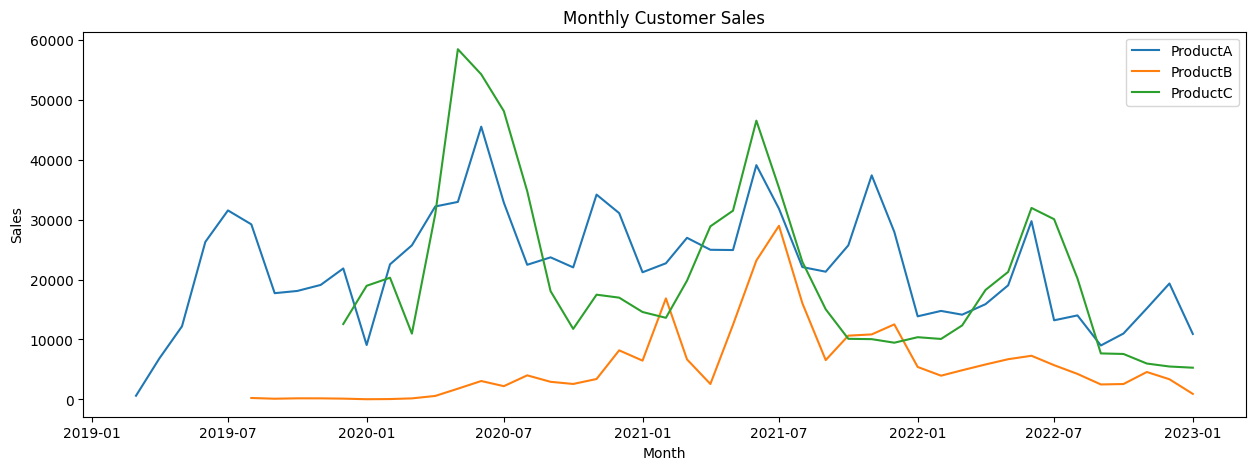

In [4]:
# Convert date column to datetime format and set as index
rawdata['Month'] = pd.to_datetime(rawdata['Month'])

# Group data by product
grouped_data = rawdata.groupby('Product')

# Initialize lists to store information
products = []
num_data_points = []
duration = []

# Iterate over groups and calculate information for each product
for product, group in grouped_data:
    products.append(product)
    num_data_points.append(len(group))
    duration.append((group['Month'].max() - group['Month'].min()).days)  # Duration in days

# Create a dataframe from the lists
product_info_df = pd.DataFrame({
    'Product': products,
    'Number of Data Points': num_data_points,
    'Duration (days)': duration
})

print(product_info_df)

# Plotting
plt.figure(figsize=(15,5))
for group_name, group_data in grouped_data:
    plt.plot(group_data['Month'], group_data['Sales'], label=group_name)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title("Monthly Customer Sales")
plt.legend()
plt.show()

### Before starting the analysis, I consider the following aspects:

1. What's important info of data?
This dataset comprises monthly sales data, indicating the importance of time-series analysis. We have various predictive modeling options, including linear regression, random forest, and XGBoost, for sales forecasting. Additionally, considering the temporal nature of the data, employing Hidden Markov models could effectively capture underlying patterns and trends.

2. What are features selected for sales estimation?
The main goal is to estimate sales figures for each product over time. This involves understanding sales fluctuations, identifying seasonal patterns, and uncovering underlying trends or irregularities.

3. Is there interdependence among product sales?
 Recognizing the potential interconnectedness or influence of product sales on each other is crucial. Factors like cross-selling, complementary products, or market trends can affect the sales performance of individual products. However, upon reviewing the line graph, it appears that there are no similar trends among the three products.

The line graph reveals that sales for the three products fluctuated over the four-year span. Notably, Product A's data appears more complete. Sales for Products A and B display clearer periodicity compared to Product C. Both Product A and B consistently reach their peak sales around July each year, reflecting a seasonal pattern. In contrast, sales for Product C remain consistently lower than the other two, with no discernible seasonal pattern. Given the clearer patterns in Products A and B, they may offer higher accuracy in predicting future sales trends.

#### Prepare supervised dataset: Feature engineering

The current dataset consists of only one variable, which is sales, to predict the sales of products. However, relying solely on the original sales data without any feature engineering may not equip the model with sufficient information to accurately predict future sales.

To address this, I utilize a method called lagging. Lagging involves creating lagged versions of the target variable (sales) for a specific number of previous months.

For instance, to predict sales for the next month, we would generate features using the sales data from the previous month. Similarly, to forecast sales for the next 6 months, we would create lagged features based on the sales data from the preceding 3 months.

In [5]:
#ProductA: adding lagged values
sales_data_A=rawdata[rawdata['Product']=='ProductA'].drop('Product',axis=1)

# Feature engineering (add lagged values as features)
for lag in range(1, 4):  # Lagged values from 1 to 3 months
        sales_data_A[f'lag{lag}'] = sales_data_A['Sales'].shift(lag)
sales_data=sales_data_A.drop(['Month'], axis=1).dropna()
sales_data.head(10)

,Sales,lag1,lag2,lag3
3,26292,12195.0,6838.0,608.0
4,31547,26292.0,12195.0,6838.0
5,29223,31547.0,26292.0,12195.0
6,17732,29223.0,31547.0,26292.0
7,18103,17732.0,29223.0,31547.0
8,19108,18103.0,17732.0,29223.0
9,21857,19108.0,18103.0,17732.0
10,9078,21857.0,19108.0,18103.0
11,22549,9078.0,21857.0,19108.0
12,25718,22549.0,9078.0,21857.0


In [6]:
len(sales_data)

44

Mean Squared Error(LR): 75664565.79611634
Mean Squared Error(RF): 75780119.22683333
Mean Squared Error(XGB): 104768557.30228043
LR_R2 Score:  -13.997671804070961
RF_R2 Score:  -6.2073702332317335
XGB_R2 Score:  -3.988090991973877


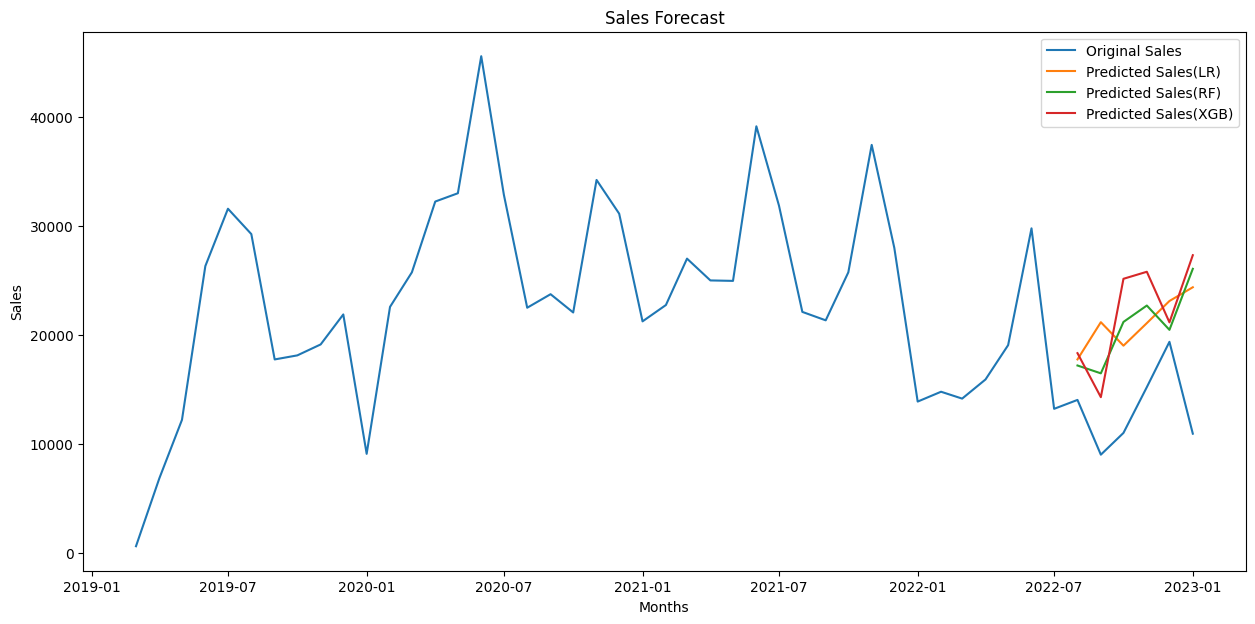

In [7]:
# Split the data into training and test sets
train_data = sales_data.iloc[:-6]
test_data = sales_data.iloc[-6:]

# Extract features and target variables
X_train, y_train = train_data.iloc[:, 1:], train_data.iloc[:, 0]
X_test, y_test = test_data.iloc[:, 1:], test_data.iloc[:, 0]

# Linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

#RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


#XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.2, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Evaluate the model
LR_mse = mean_squared_error(y_test, lr_pred)
RF_mse = mean_squared_error(y_test, rf_pred)
XGB_mse = mean_squared_error(y_test, xgb_pred)
print("Mean Squared Error(LR):", LR_mse)
print("Mean Squared Error(RF):", RF_mse)
print("Mean Squared Error(XGB):",XGB_mse)
LR_r2 = r2_score(lr_pred, y_test)
RF_r2 = r2_score(rf_pred,y_test)
XGB_r2 = r2_score(xgb_pred, y_test)
print('LR_R2 Score: ', LR_r2)
print('RF_R2 Score: ', RF_r2)
print('XGB_R2 Score: ', XGB_r2)

plt.figure(figsize=(15,7))
plt.plot(sales_data_A['Month'], sales_data_A['Sales'])
plt.plot(sales_data_A['Month'][-6:], lr_pred)#linear
plt.plot(sales_data_A['Month'][-6:], rf_pred)#randomforest
plt.plot(sales_data_A['Month'][-6:], xgb_pred)#xgboost
plt.title("Sales Forecast")
plt.xlabel("Months")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales(LR)","Predicted Sales(RF)","Predicted Sales(XGB)"])
plt.show()

Based on the Mean Squared Error (MSE) evaluation, the Random Forest (RF) model exhibited the lowest error compared to both Linear Regression and XGBoost. As a result, I've opted to utilize the Random Forest model to forecast the sales for the upcoming six months.

In [8]:
next_6_months_predictions = []
X_next_6_months = sales_data.iloc[-1:, 1:] 
for month in range(1, 7):  # Predicting the next 6 months
    # Make prediction for the next month
    prediction = rf_model.predict(X_next_6_months)
    next_6_months_predictions.append(prediction[0])  # Append the prediction to the list
    
    # Update X_next_6_months for the next prediction
    X_next_6_months = X_next_6_months.shift(-1, axis=1)  # Shift lagged features by 1 month for the next prediction
    X_next_6_months.iloc[:, -1] = prediction[0]  # Update the last lagged feature with the current prediction

# Create a DataFrame to display the predictions
start_date = pd.Timestamp('2023-02-01')
predicted_sales_df = pd.DataFrame({
    'Month': pd.date_range(start=start_date, periods=6, freq='MS'),
    'Predicted Sales': next_6_months_predictions
})

print(predicted_sales_df)

       Month  Predicted Sales
0 2023-02-01         26038.66
1 2023-03-01         17597.29
2 2023-04-01         21764.45
3 2023-05-01         26369.04
4 2023-06-01         21548.68
5 2023-07-01         21378.12


#### ProductB

Mean Squared Error(LR): 3970910.3762066513
Mean Squared Error(RF): 12317317.388716668
Mean Squared Error(XGB): 6806400.172467232
LR_R2 Score:  -4.795430921337934
RF_R2 Score:  -6.606081730058717
XGB_R2 Score:  -1.4668669700622559


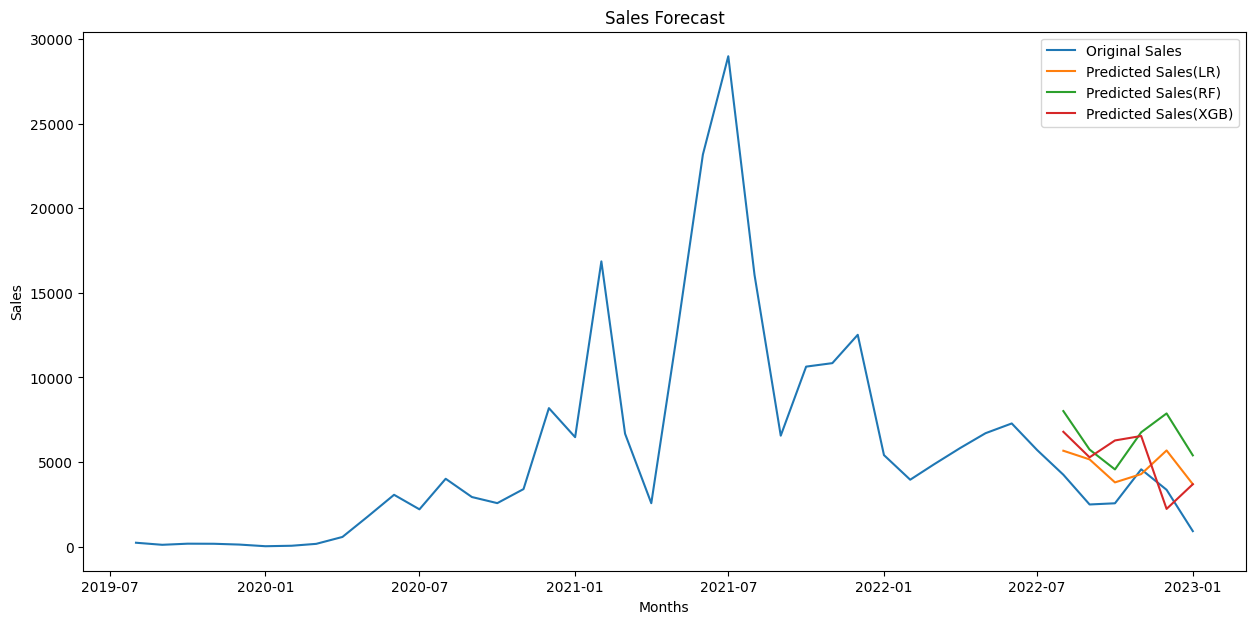

In [9]:
#ProductB
sales_data_B=rawdata[rawdata['Product']=='ProductB'].drop('Product',axis=1)

# Feature engineering (add lagged values as features)
for lag in range(1, 4):  # Lagged values from 1 to 3 months
        sales_data_B[f'lag{lag}'] = sales_data_B['Sales'].shift(lag)
sales_data=sales_data_B.drop(['Month'], axis=1).dropna()
# Split the data into training and test sets
train_data = sales_data.iloc[:-6]
test_data = sales_data.iloc[-6:]


# Extract features and target variables
X_train, y_train = train_data.iloc[:, 1:], train_data.iloc[:, 0]
X_test, y_test = test_data.iloc[:, 1:], test_data.iloc[:, 0]

# Linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

#RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


#XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.2, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Evaluate the model
LR_mse = mean_squared_error(y_test, lr_pred)
RF_mse = mean_squared_error(y_test, rf_pred)
XGB_mse = mean_squared_error(y_test, xgb_pred)
print("Mean Squared Error(LR):", LR_mse)
print("Mean Squared Error(RF):", RF_mse)
print("Mean Squared Error(XGB):",XGB_mse)
LR_r2 = r2_score(lr_pred, y_test)
RF_r2 = r2_score(rf_pred,y_test)
XGB_r2 = r2_score(xgb_pred, y_test)
print('LR_R2 Score: ', LR_r2)
print('RF_R2 Score: ', RF_r2)
print('XGB_R2 Score: ', XGB_r2)

plt.figure(figsize=(15,7))
plt.plot(sales_data_B['Month'], sales_data_B['Sales'])
plt.plot(sales_data_B['Month'][-6:], lr_pred)#linear
plt.plot(sales_data_B['Month'][-6:], rf_pred)#randomforest
plt.plot(sales_data_B['Month'][-6:], xgb_pred)#xgboost
plt.title("Sales Forecast")
plt.xlabel("Months")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales(LR)","Predicted Sales(RF)","Predicted Sales(XGB)"])
plt.show()

In [10]:
# utilize the linear regression model to forecast the sales for the upcoming six months
next_6_months_predictions = []
for month in range(1, 7):  # Predicting the next 6 months
    # Make prediction for the next month
    prediction = lr_model.predict(X_next_6_months)
    next_6_months_predictions.append(prediction[0])  # Append the prediction to the list
    
    # Update X_next_6_months for the next prediction
    X_next_6_months = X_next_6_months.shift(-1, axis=1)  # Shift lagged features by 1 month for the next prediction
    X_next_6_months.iloc[:, -1] = prediction[0]  # Update the last lagged feature with the current prediction

# Create a DataFrame to display the predictions
start_date = pd.Timestamp('2023-02-01')
predicted_sales_df = pd.DataFrame({
    'Month': pd.date_range(start=start_date, periods=6, freq='MS'),
    'Predicted Sales': next_6_months_predictions
})

print(predicted_sales_df)

       Month  Predicted Sales
0 2023-02-01     21993.517002
1 2023-03-01     17763.811489
2 2023-04-01     16305.867913
3 2023-05-01     18397.474181
4 2023-06-01     15643.431989
5 2023-07-01     12699.029732


#### ProductC

Mean Squared Error(LR): 45181612.64430965
Mean Squared Error(RF): 109142963.60641669
Mean Squared Error(XGB): 42528300.82586511
LR_R2 Score:  -0.18558863972652384
RF_R2 Score:  -0.022926304323036995
XGB_R2 Score:  0.1405351758003235


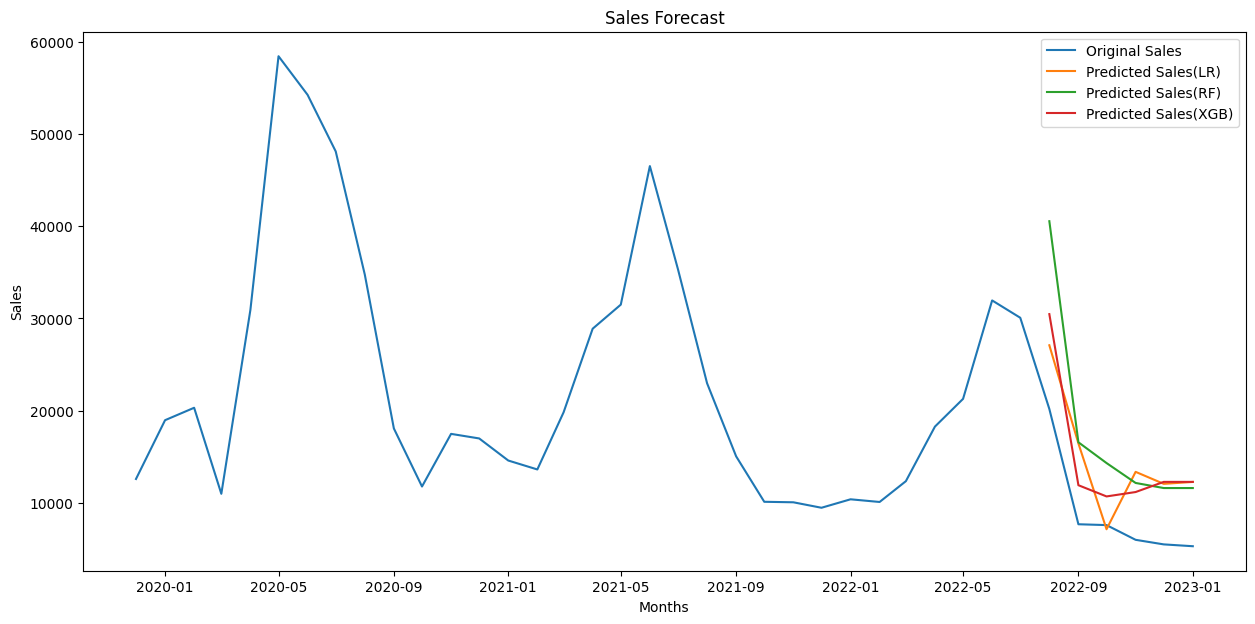

In [11]:
#ProuductC
sales_data_C=rawdata[rawdata['Product']=='ProductC'].drop('Product',axis=1)

# Feature engineering (add lagged values as features)
for lag in range(1, 4):  # Lagged values from 1 to 3 months
        sales_data_C[f'lag{lag}'] = sales_data_C['Sales'].shift(lag)
sales_data=sales_data_C.drop(['Month'], axis=1).dropna()
# Split the data into training and test sets
train_data = sales_data.iloc[:-6]
test_data = sales_data.iloc[-6:]

# Extract features and target variables
X_train, y_train = train_data.iloc[:, 1:], train_data.iloc[:, 0]
X_test, y_test = test_data.iloc[:, 1:], test_data.iloc[:, 0]

# Linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

#RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


#XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.2, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Evaluate the model
LR_mse = mean_squared_error(y_test, lr_pred)
RF_mse = mean_squared_error(y_test, rf_pred)
XGB_mse = mean_squared_error(y_test, xgb_pred)
print("Mean Squared Error(LR):", LR_mse)
print("Mean Squared Error(RF):", RF_mse)
print("Mean Squared Error(XGB):",XGB_mse)
LR_r2 = r2_score(lr_pred, y_test)
RF_r2 = r2_score(rf_pred,y_test)
XGB_r2 = r2_score(xgb_pred, y_test)
print('LR_R2 Score: ', LR_r2)
print('RF_R2 Score: ', RF_r2)
print('XGB_R2 Score: ', XGB_r2)

plt.figure(figsize=(15,7))
plt.plot(sales_data_C['Month'], sales_data_C['Sales'])
plt.plot(sales_data_C['Month'][-6:], lr_pred)#linear
plt.plot(sales_data_C['Month'][-6:], rf_pred)#randomforest
plt.plot(sales_data_C['Month'][-6:], xgb_pred)#xgboost
plt.title("Sales Forecast")
plt.xlabel("Months")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales(LR)","Predicted Sales(RF)","Predicted Sales(XGB)"])
plt.show()

In [12]:
#utilize the XGBoost model to forecast the sales for the upcoming six months
next_6_months_predictions = []
for month in range(1, 7):  # Predicting the next 6 months
    # Make prediction for the next month
    prediction = xgb_model.predict(X_next_6_months)
    next_6_months_predictions.append(prediction[0])  # Append the prediction to the list
    
    # Update X_next_6_months for the next prediction
    X_next_6_months = X_next_6_months.shift(-1, axis=1)  # Shift lagged features by 1 month for the next prediction
    X_next_6_months.iloc[:, -1] = prediction[0]  # Update the last lagged feature with the current prediction

# Create a DataFrame to display the predictions
start_date = pd.Timestamp('2023-02-01')
predicted_sales_df = pd.DataFrame({
    'Month': pd.date_range(start=start_date, periods=6, freq='MS'),
    'Predicted Sales': next_6_months_predictions
})

print(predicted_sales_df)

       Month  Predicted Sales
0 2023-02-01     18537.460938
1 2023-03-01     17236.582031
2 2023-04-01     14679.552734
3 2023-05-01     18610.015625
4 2023-06-01     17002.978516
5 2023-07-01     11398.041992


#### Brief summary and the next step: lagged value of pre-defined seasons
After employing lagged values from monthly sales to capture seasonal patterns and applying predictive models such as linear regression, random forest, and XGBoost for sales forecasting, it became apparent that my approach fell short. The models yielded high Mean Squared Error (MSE) and negative R-squared values, indicating subpar performance. To potentially improve prediction accuracy, I decided to categorize seasons and then apply lagged values. I specifically chose to focus on Product A, which exhibited the least accurate predictions among the three products, with the goal of pinpointing areas for enhancement.

Mean Squared Error: 110369177.05229817


C:\Users\Una\AppData\Local\Temp\ipykernel_520\3084843976.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data.at[i, 'Month_1'] = sales_data.at[i, 'Month'].month
C:\Users\Una\AppData\Local\Temp\ipykernel_520\3084843976.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data['Winter'] = ((sales_data['Month_1'] == 12) | (sales_data['Month_1'] <= 2)).astype(int)
C:\Users\Una\AppData\Local\Temp\ipykernel_520\3084843976.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

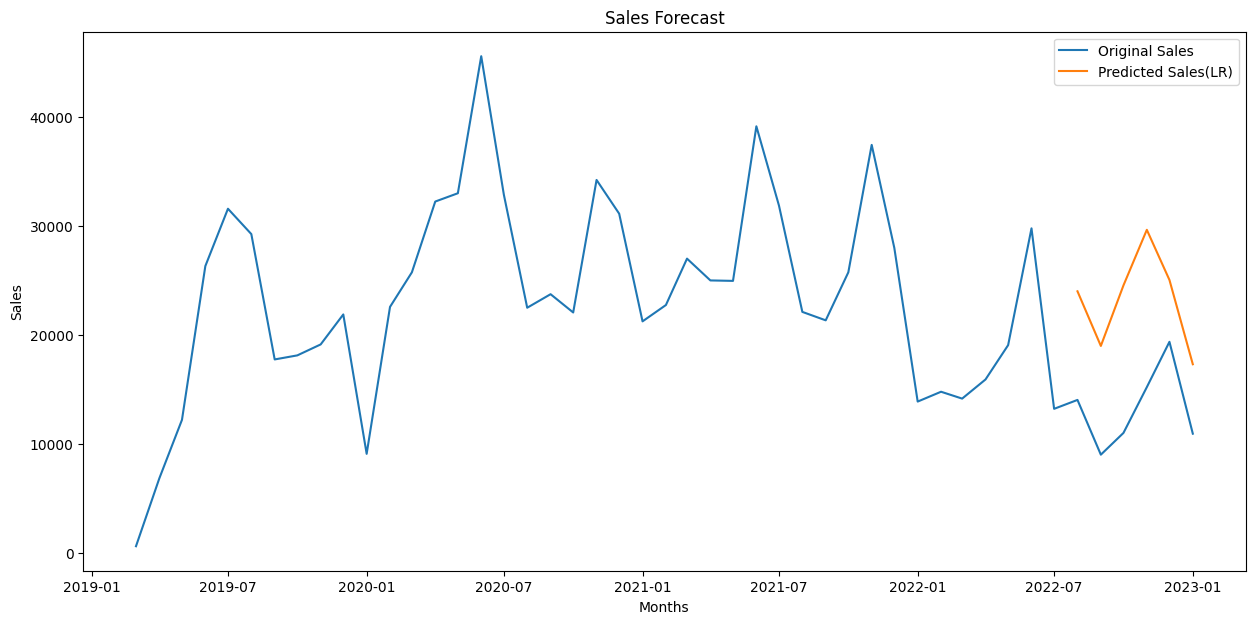

In [13]:
sales_data_1 = rawdata[rawdata['Product'] == 'ProductA']
sales_data = rawdata[rawdata['Product'] == 'ProductA']
for i in sales_data.index:
    # Extract the month from each date in the 'Month' column and assign it back to the same column
    sales_data.at[i, 'Month_1'] = sales_data.at[i, 'Month'].month


# Create seasonal indicator variables for each season
sales_data['Winter'] = ((sales_data['Month_1'] == 12) | (sales_data['Month_1'] <= 2)).astype(int)
sales_data['Spring'] = ((sales_data['Month_1'] >= 3) & (sales_data['Month_1'] <= 5)).astype(int)
sales_data['Summer'] = ((sales_data['Month_1'] >= 6) & (sales_data['Month_1'] <= 8)).astype(int)
sales_data['Fall'] = ((sales_data['Month_1'] >= 9) & (sales_data['Month_1'] <= 11)).astype(int)


sales_data.drop(['Month','Product','Month_1'], axis=1, inplace=True)

# Feature engineering (add lagged values as features)
lag_months = 3  

# Create lagged features for each seasonal indicator variable
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    for lag in range(1, lag_months + 1):
        sales_data[f'{season}_lag{lag}'] = sales_data[season].shift(lag)
sales_data.dropna(inplace=True)

# Train LR model
train_data = sales_data.iloc[:-6]
test_data = sales_data.iloc[-6:]

X_train, y_train = train_data.drop('Sales', axis=1), train_data['Sales']
X_test, y_test = test_data.drop('Sales', axis=1), test_data['Sales']

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

plt.figure(figsize=(15,7))
plt.plot(sales_data_1['Month'], sales_data_1['Sales'])
plt.plot(sales_data_1['Month'][-6:], predictions)#linear

plt.title("Sales Forecast")
plt.xlabel("Months")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales(LR)"])
plt.show()

The MSE value did not show improvement; however, the trend of the predicted values seems to closely follow the actual values.

### Trying to use HMM and see how the prediction is
This method captures underlying patterns or states in time-series data that may not be directly observable.

Model is not converging.  Current: -425.24996470195754 is not greater than -408.07780588351136. Delta is -17.172158818446178
Model is not converging.  Current: -348.16398487304184 is not greater than -345.5524874672871. Delta is -2.611497405754733
Model is not converging.  Current: -328.74507796164255 is not greater than -328.74394809133247. Delta is -0.0011298703100806051


Mean Squared Error for each product: {'ProductA': np.float64(358856815.6563544), 'ProductB': np.float64(16787792.068571452), 'ProductC': np.float64(82997455.3883189)}


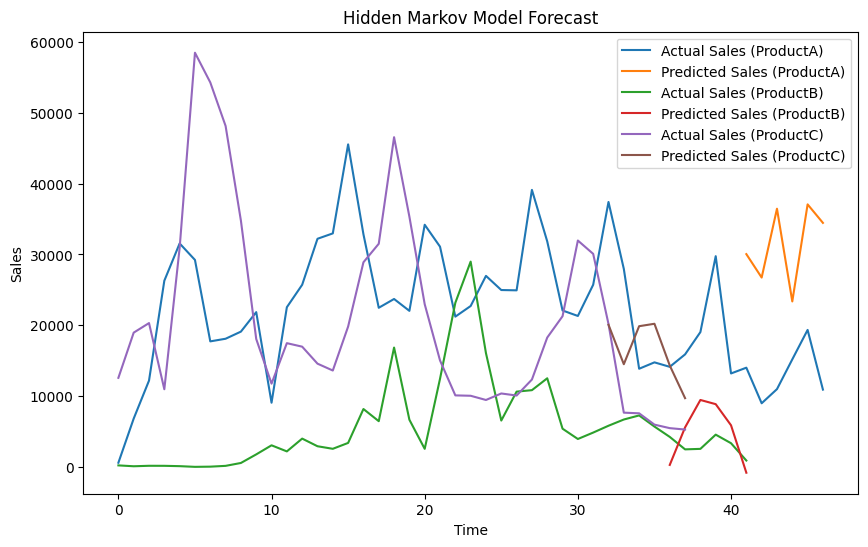

In [14]:
# Create sales of three products in a dataframe
product_sales_data = {} 

for product in rawdata['Product'].unique():
    product_sales_data[product] = rawdata[rawdata['Product'] == product]['Sales'].values.reshape(-1, 1)

# Train-test split for each product
train_data = {product: sales[:-6] for product, sales in product_sales_data.items()}
test_data = {product: sales[-6:] for product, sales in product_sales_data.items()}

# Define and train the Hidden Markov Model for each product
models = {}
for product, sales in train_data.items():
    model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
    model.fit(sales)
    models[product] = model

# Predict sales for each product
predicted_sales = {}
for product, sales in test_data.items():
    hidden_states = models[product].predict(train_data[product])
    predicted_sales[product], _ = models[product].sample(len(test_data[product]))

# Calculate mean squared error
mse = {product: mean_squared_error(test_data[product], predicted_sales[product]) for product in test_data}
print("Mean Squared Error for each product:", mse)

# Visualize the results
plt.figure(figsize=(10, 6))
for product, sales in product_sales_data.items():
    plt.plot(sales, label=f'Actual Sales ({product})')
    plt.plot(np.arange(len(train_data[product]), len(train_data[product]) + len(test_data[product])),
             predicted_sales[product], label=f'Predicted Sales ({product})')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Hidden Markov Model Forecast')
plt.legend()
plt.show()


#### SARIMAX
After exploring various methods, I found that the SARIMAX package in Python outperforms my previous prediction approach.
 SARIMAX allows for precise configuration using parameters such as autoregressive and moving average terms, along with seasonal components. Its ability to capture both trend and seasonality results in more accurate forecasts.

C:\Users\Una\AppData\Local\Temp\ipykernel_520\2441293422.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_data['Month'] = pd.to_datetime(sales_data['Month'])
C:\Users\Una\AppData\Local\Temp\ipykernel_520\2441293422.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sales_data_monthly = sales_data.resample('M').sum().fillna(0)
c:\Users\Una\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


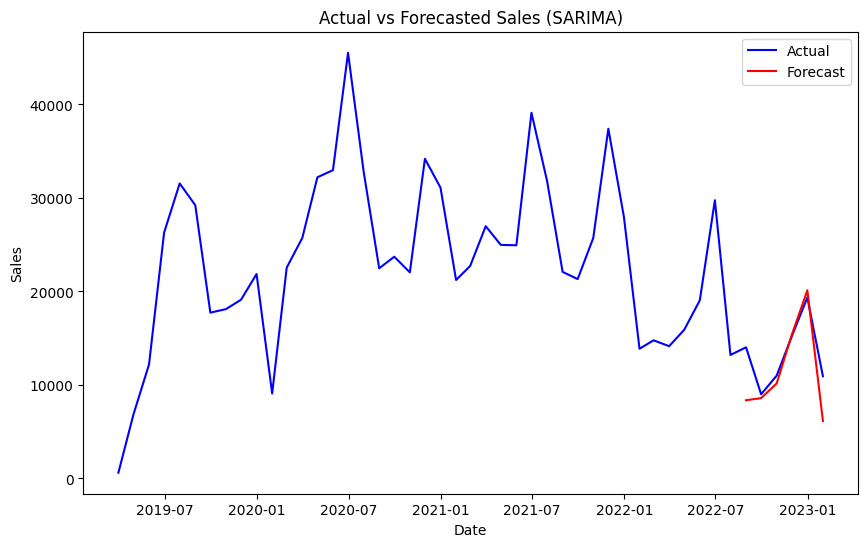

Mean Squared Error: 9410065.142720606


In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

sales_data = rawdata[rawdata['Product'] == 'ProductA']

# Convert date column to datetime format and set as index
sales_data['Month'] = pd.to_datetime(sales_data['Month'])
sales_data.set_index('Month', inplace=True)

# Resample data to monthly frequency and fill missing values
sales_data_monthly = sales_data.resample('M').sum().fillna(0)

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_data_monthly['Sales'], model='additive')

# Seasonal modeling (SARIMA)
model = SARIMAX(sales_data_monthly['Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 6))
results = model.fit()

# Forecast future sales
forecast = results.forecast(steps=6)

# Align forecast with actual sales data
forecast_aligned = pd.Series(forecast.values, index=sales_data_monthly.index[-6:])

# Plot actual vs forecasted sales
plt.figure(figsize=(10, 6))
plt.plot(sales_data_monthly.index, sales_data_monthly['Sales'], label='Actual', color='blue')
plt.plot(forecast_aligned.index, forecast_aligned, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Forecasted Sales (SARIMA)')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(sales_data_monthly['Sales'][-6:], forecast_aligned)
print("Mean Squared Error:", mse)



In this sales forecasting dataset, feature engineering stands out as a crucial step, offering valuable insights from past sales data. By extracting and transforming important features like lagged values and seasonal indicators, we can uncover patterns and trends that help make accurate predictions. This process lets us capture the ups and downs of sales behavior, ensuring our forecasting models are reliable. Ultimately, effective feature engineering sets the stage for informed decision-making and efficient resource allocation in businesses.